In [1]:
%load_ext lab_black

from scipy.interpolate import CubicSpline
from scipy import stats
import numpy as np
import admix
import pandas as pd
import itertools
import os
import glob
from tqdm import tqdm
import admix_genet_cor
import matplotlib.pyplot as plt

In [2]:
SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp_tables.xlsx?dl=1"
ROOT_DIR = (
    "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr"
)
PFILE_DIR = os.path.join(ROOT_DIR, "imputed")
trait_list = [
    f.split("/")[-1].split(".")[0]
    for f in glob.glob(os.path.join("out/pheno", "*.tsv"))
]
# trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="trait-info")
# trait_list = trait_info["trait"].values
# # trait_list = [trait for trait in trait_list if trait not in ["height", "bmi"]]
# dict_trait_display_name = {
#     row["trait"]: row["display-name"] for _, row in trait_info.iterrows()
# }

In [12]:
trait_list = list(
    set(trait_list) - set(["hypertension", "height", "bmi", "total_wbc_cnt"])
)
trait_list = [t for t in trait_list if not "duffy" in t]

In [13]:
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            ["hm3", "imputed"],
            ["mafukb", "gcta"],
            [0.005, 0.05],
        )
    ],
    columns=[
        "snpset",
        "hermodel",
        "maf",
    ],
)

df_params["grm_prefix"] = df_params.apply(
    lambda p: f"{p.snpset}.{p.hermodel}.{str(p.maf)[2:]}",
    axis=1,
)
df_params = pd.DataFrame(
    [params for params in itertools.product(df_params.grm_prefix, trait_list)],
    columns=["grm_prefix", "trait"],
)

In [17]:
dict_loglik = {trait: dict() for trait in trait_list}
rho_list = np.linspace(0, 1, 21)
xs = np.linspace(0, 1, 1001)

for i, param in tqdm(df_params.iterrows(), total=len(df_params)):
    if param.trait != "mean_corp_hgb_conc":
        continue
        
    est_dir = f"out-newPC/gcta-estimate/{param.trait}-{param.grm_prefix}"
    loglik_list = [
        admix.tools.gcta.read_reml(os.path.join(est_dir, f"rho{int(rho * 100)}"))[
            "loglik"
        ]
        for rho in rho_list
    ]
    cs = CubicSpline(rho_list, loglik_list)
    ll = cs(xs)
    dict_loglik[param.trait][param.grm_prefix] = ll

100%|██████████| 160/160 [00:03<00:00, 47.20it/s]


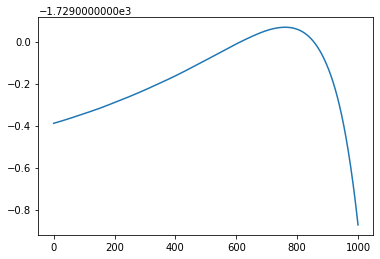

In [39]:
plt.plot(dict_loglik["mean_corp_hgb_conc"]["hm3.mafukb.005"])

In [34]:
est_dir = f"out/gcta-estimate/mean_corp_hgb_conc-hm3.mafukb.005"
loglik_list = [
    admix.tools.gcta.read_reml(os.path.join(est_dir, f"rho{int(rho * 100)}"))["loglik"]
    for rho in rho_list
]
cs = CubicSpline(rho_list, loglik_list)
ll = cs(xs)

In [35]:
admix_genet_cor.hdi(xs, dict_loglik["mean_corp_hgb_conc"]["hm3.mafukb.005"])

(0.023, 0.9500000000000001)

In [68]:
for grm_prefix in df_params.grm_prefix.unique():
    meta_ll = 0
    for trait in trait_list:
        meta_ll += dict_loglik[trait][grm_prefix]
    print(grm_prefix, meta_ll.argmax() / 1000, admix_genet_cor.hdi(xs, meta_ll))

hm3.mafukb.005 0.928 (0.872, 0.972)
hm3.mafukb.05 0.902 (0.839, 0.9500000000000001)
hm3.gcta.005 0.939 (0.89, 0.978)
hm3.gcta.05 0.909 (0.85, 0.9540000000000001)
imputed.mafukb.005 0.881 (0.801, 0.9420000000000001)
imputed.mafukb.05 0.824 (0.729, 0.896)
imputed.gcta.005 0.892 (0.8190000000000001, 0.9470000000000001)
imputed.gcta.05 0.833 (0.743, 0.901)


In [15]:
df_plot = {"trait": [], "grm_prefix": [], "mode": [], "lower": [], "upper": []}

for i, param in tqdm(df_params.iterrows(), total=len(df_params)):
    trait, grm_prefix = param.trait, param.grm_prefix
    mode = dict_loglik[trait][grm_prefix].argmax() / 1000
    interval = admix_genet_cor.hdi(xs, dict_loglik[trait][grm_prefix])
    if isinstance(interval, list):
        print(f"skipping {trait}, {grm_prefix}, which has more than 1 interval")
        continue
    df_plot["trait"].append(trait)
    df_plot["grm_prefix"].append(grm_prefix)
    df_plot["mode"].append(mode)
    df_plot["lower"].append(interval[0])
    df_plot["upper"].append(interval[1])
df_plot = pd.DataFrame(df_plot)
df_plot["length"] = df_plot["upper"] - df_plot["lower"]

100%|██████████| 160/160 [00:00<00:00, 860.09it/s]


In [16]:
df_plot_old = pd.read_csv("results/all-duffy-covar.tsv", sep="\t")

In [17]:
df_plot_old2 = pd.read_csv("../03-page-genome-wide/results/all-estimates.tsv", sep="\t")

In [57]:
df_tmp = df_plot_old2[
    (df_plot_old2.hermodel == "mafukb")
    & (df_plot_old2.trait.isin(trait_list))
    & (df_plot_old2.duffy_covar == True)
].set_index("trait")

In [58]:
df_tmp2 = df_plot_old[df_plot_old.grm_prefix == "imputed.mafukb.005"].set_index("trait")

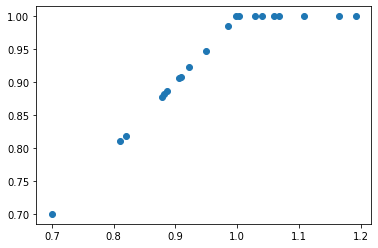

In [60]:
plt.scatter(df_tmp.rg, df_tmp2["mode"].reindex(df_tmp.index))

In [63]:
df_merged = pd.merge(df_plot, df_plot_old, on=["trait", "grm_prefix"])
df_merged = df_merged[df_merged.grm_prefix == "imputed.mafukb.005"]

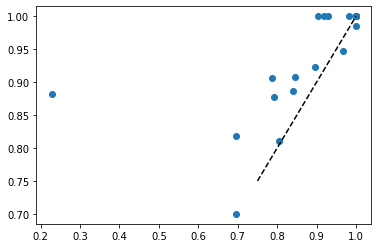

In [66]:
plt.scatter(df_merged["mode_x"], df_merged["mode_y"])
plt.plot([0.75, 1.0], [0.75, 1.0], ls="--", color="k")